**Load Dataset**

In [3]:
# Import necessary libraries for modeling and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

# Load the Energy Efficiency Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
data = pd.read_excel(url)


**Data Preprocessing**

In [4]:
# Display dataset information
print(data.info())
print(data.head())

# Rename columns for better readability
data.columns = [
    "Relative_Compactness",
    "Surface_Area",
    "Wall_Area",
    "Roof_Area",
    "Overall_Height",
    "Orientation",
    "Glazing_Area",
    "Glazing_Area_Distribution",
    "Heating_Load",
    "Cooling_Load",
]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB
None
     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28


**Exploratory Data Analysis**


---


Correlation Heatmap

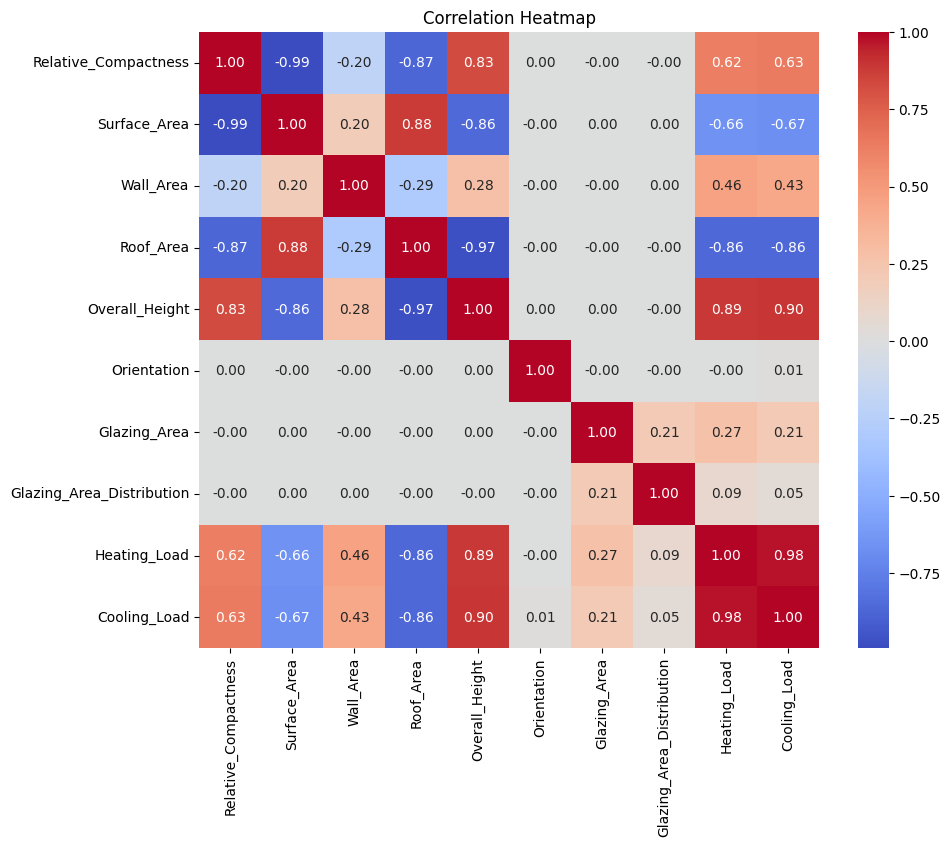

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Pairplot of Features

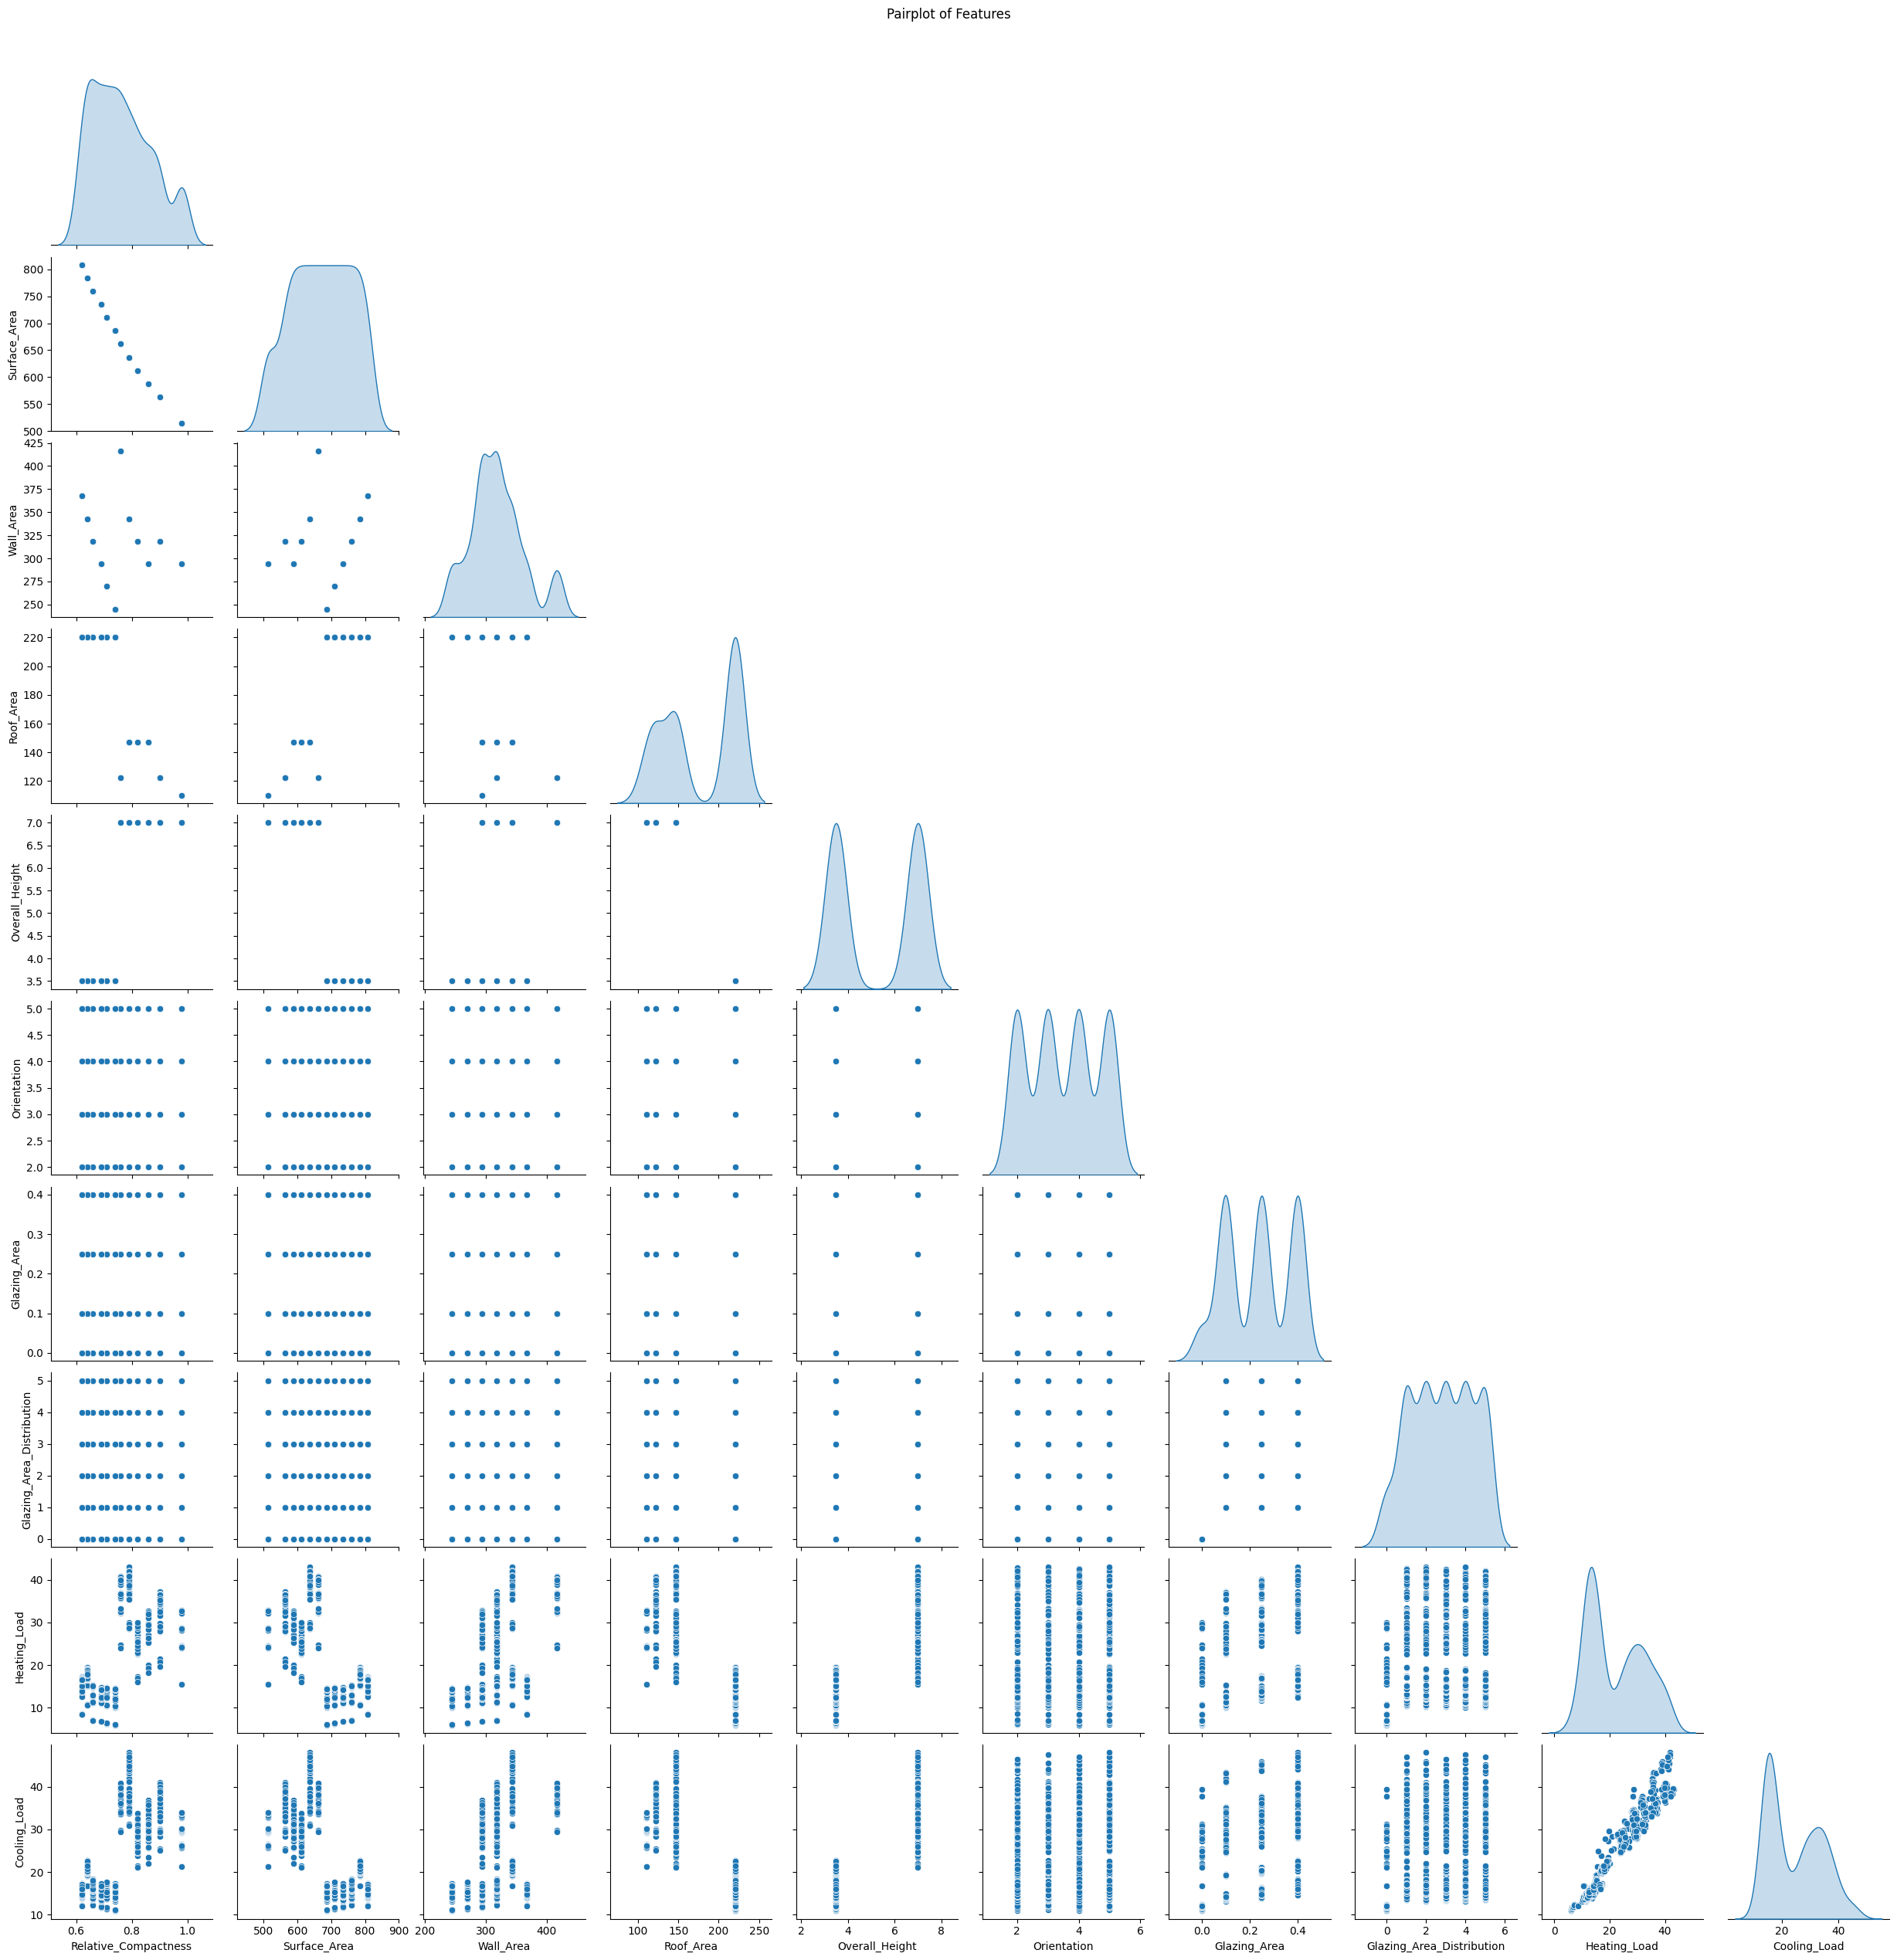

In [6]:
sns.pairplot(data, diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()


Distribution of Heating Load

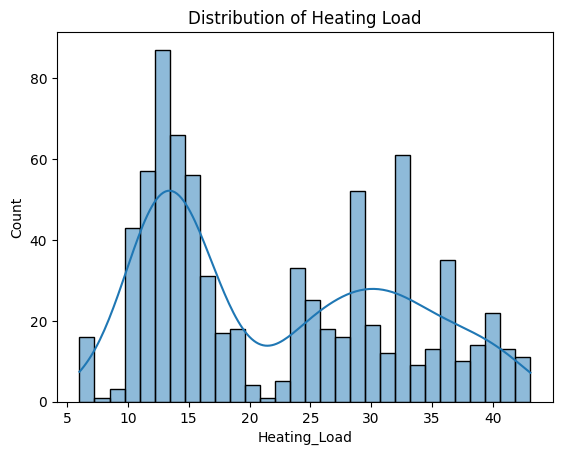

In [7]:
# Distribution of Heating Load
sns.histplot(data["Heating_Load"], kde=True, bins=30)
plt.title("Distribution of Heating Load")
plt.show()

Distribution of Cooling Load

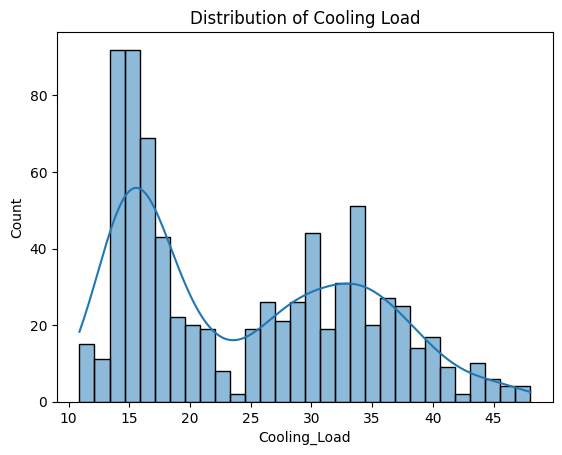

In [8]:
# Distribution of Cooling Load
sns.histplot(data["Cooling_Load"], kde=True, bins=30)
plt.title("Distribution of Cooling Load")
plt.show()

Boxplot for Outliers

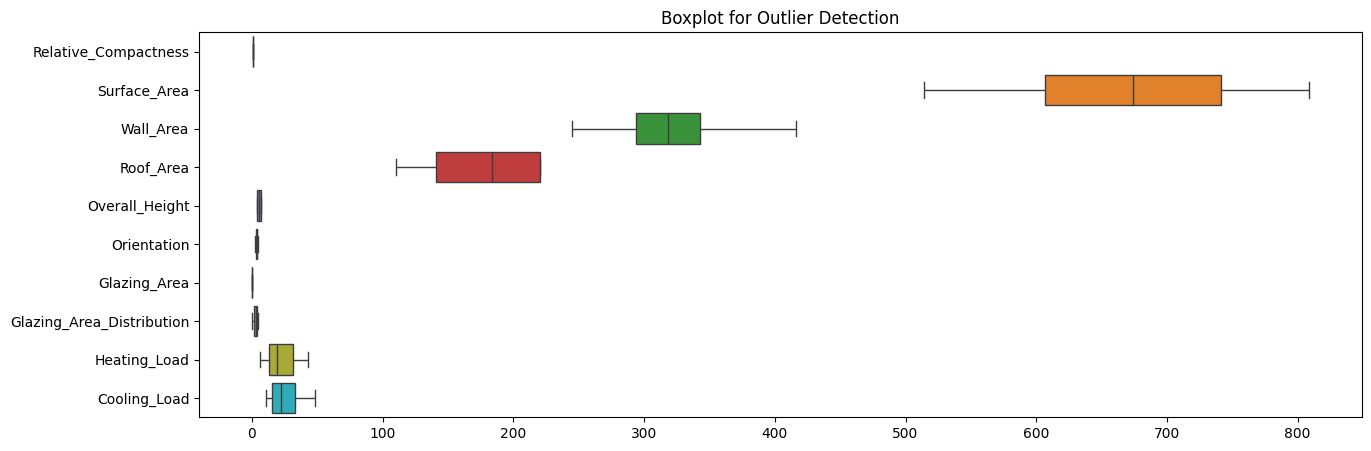

In [9]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=data, orient="h")
plt.title("Boxplot for Outlier Detection")
plt.show()


**Machine Learning Models**


---

Data Preprocessing

In [10]:
# Define predictors and target variables
X = data.drop(columns=["Heating_Load", "Cooling_Load"])
y_heating = data["Heating_Load"]
y_cooling = data["Cooling_Load"]

# Split into training and testing sets
X_train, X_test, y_train_heating, y_test_heating = train_test_split(
    X, y_heating, test_size=0.2, random_state=42
)
X_train, X_test, y_train_cooling, y_test_cooling = train_test_split(
    X, y_cooling, test_size=0.2, random_state=42
)


Model Training


In [11]:
# Define evaluation function
def evaluate_model(model, X_test, y_test, predictions):
    print("Model Performance:")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, predictions):.2f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, predictions):.2f}")
    print(f"R-squared (R2): {r2_score(y_test, predictions):.2f}")

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train_heating)
predictions_lr_heating = lr.predict(X_test)
print("Linear Regression (Heating Load):")
evaluate_model(lr, X_test, y_test_heating, predictions_lr_heating)

lr.fit(X_train, y_train_cooling)
predictions_lr_cooling = lr.predict(X_test)
print("Linear Regression (Cooling Load):")
evaluate_model(lr, X_test, y_test_cooling, predictions_lr_cooling)

# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train_heating)
predictions_rf_heating = rf.predict(X_test)
print("Random Forest (Heating Load):")
evaluate_model(rf, X_test, y_test_heating, predictions_rf_heating)

rf.fit(X_train, y_train_cooling)
predictions_rf_cooling = rf.predict(X_test)
print("Random Forest (Cooling Load):")
evaluate_model(rf, X_test, y_test_cooling, predictions_rf_cooling)


Linear Regression (Heating Load):
Model Performance:
Mean Absolute Error (MAE): 2.18
Mean Squared Error (MSE): 9.15
R-squared (R2): 0.91
Linear Regression (Cooling Load):
Model Performance:
Mean Absolute Error (MAE): 2.20
Mean Squared Error (MSE): 9.90
R-squared (R2): 0.89
Random Forest (Heating Load):
Model Performance:
Mean Absolute Error (MAE): 0.35
Mean Squared Error (MSE): 0.24
R-squared (R2): 1.00
Random Forest (Cooling Load):
Model Performance:
Mean Absolute Error (MAE): 1.06
Mean Squared Error (MSE): 2.93
R-squared (R2): 0.97


Hyperparameter Tuning

In [12]:
# Grid Search for Random Forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train_heating)
print(f"Best Parameters for Heating Load: {grid_search.best_params_}")
best_rf_heating = grid_search.best_estimator_

grid_search.fit(X_train, y_train_cooling)
print(f"Best Parameters for Cooling Load: {grid_search.best_params_}")
best_rf_cooling = grid_search.best_estimator_


Best Parameters for Heating Load: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Parameters for Cooling Load: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


**Forecasting**

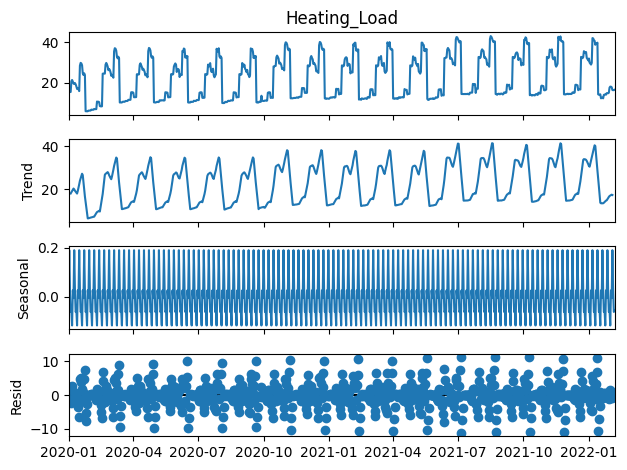

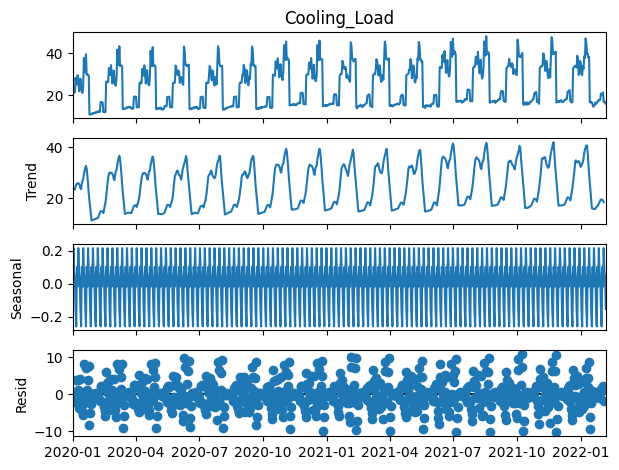

In [13]:
# Generate a time index
data["Time_Index"] = pd.date_range(start="2020-01-01", periods=len(data), freq="D")
data.set_index("Time_Index", inplace=True)

# Decompose Heating Load
result_heating = seasonal_decompose(data["Heating_Load"], model="additive")
result_heating.plot()
plt.show()

# Decompose Cooling Load
result_cooling = seasonal_decompose(data["Cooling_Load"], model="additive")
result_cooling.plot()
plt.show()


Exponential Smoothing

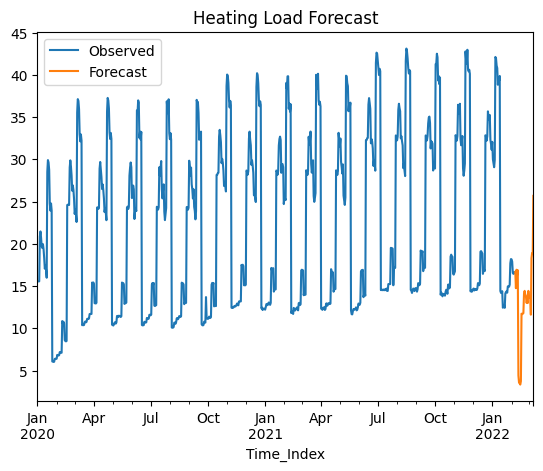

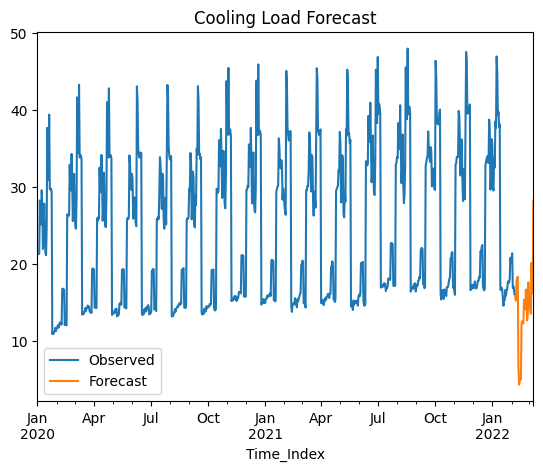

In [15]:
# Heating Load
model_heating = ExponentialSmoothing(data["Heating_Load"], trend="add", seasonal="add", seasonal_periods=365)
fit_heating = model_heating.fit()
forecast_heating = fit_heating.forecast(30)
data["Heating_Load"].plot(label="Observed", legend=True)
forecast_heating.plot(label="Forecast", legend=True)
plt.title("Heating Load Forecast")
plt.show()

# Cooling Load
model_cooling = ExponentialSmoothing(data["Cooling_Load"], trend="add", seasonal="add", seasonal_periods=365)
fit_cooling = model_cooling.fit()
forecast_cooling = fit_cooling.forecast(30)
data["Cooling_Load"].plot(label="Observed", legend=True)
forecast_cooling.plot(label="Forecast", legend=True)
plt.title("Cooling Load Forecast")
plt.show()
